In [1]:
!pip install --upgrade --quiet google-cloud-aiplatform mlflow joblib scikit-learn pandas matplotlib

In [2]:
# CONFIGURATION
PROJECT_ID = "steadfast-canto-473315-v8"
LOCATION = "us-central1"
BUCKET_URI = f"gs://week8-assignment-mlops-steadfast-canto-473315-v8-unique"
MODEL_ARTIFACT_DIR = "my-model/iris-classifier-week-1"
MODEL_DISPLAY_NAME = "IRIS-classifier-dt"

In [3]:
# SETUP GCS & ENVIRONMENT
!gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI} || echo "Bucket already exists"
!gsutil cp iris.csv {BUCKET_URI}/data/iris.csv

Creating gs://week8-assignment-mlops-steadfast-canto-473315-v8-unique/...
ServiceException: 409 A Cloud Storage bucket named 'week8-assignment-mlops-steadfast-canto-473315-v8-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Bucket already exists
Copying file://iris.csv [Content-Type=text/csv]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


In [4]:
import mlflow
from mlflow import MlflowClient
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set MLflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:8100")
mlflow.set_experiment("IRIS Data Poison Experimentss")
client = MlflowClient(mlflow.get_tracking_uri())

print("Tracking URI:", mlflow.get_tracking_uri())

2025/11/13 12:49:30 INFO mlflow.tracking.fluent: Experiment with name 'IRIS Data Poison Experimentss' does not exist. Creating a new experiment.


Tracking URI: http://127.0.0.1:8100


In [5]:
# Load dataset from GCS
data = pd.read_csv("iris.csv")  # You can also pull from GCS if needed

# Encode categorical species
if data["species"].dtype == "object":
    data["species"] = data["species"].astype("category").cat.codes

# Separate features and target
X = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = data["species"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

In [6]:
# Safe data poisoning function (only affects numeric features)
def poison_data(X, level=0.05):
    """Add Gaussian noise to feature matrix at specified poison level."""
    X_poisoned = X.copy()
    n_samples = int(len(X) * level)
    idx = np.random.choice(X.index, n_samples, replace=False)
    noise = np.random.normal(0, 0.5, size=(n_samples, X.shape[1]))
    X_poisoned.loc[idx] += noise
    return X_poisoned

# Poisoning levels
poison_levels = [0.0, 0.05, 0.10, 0.50]
results = []

for level in poison_levels:
    print(f"\n Training with {int(level*100)}% poisoned data")

    # Poison only training data (not labels!)
    X_train_poisoned = poison_data(X_train, level=level)

    with mlflow.start_run(run_name=f"Poison_{int(level*100)}%"):
        params = {"max_depth": 3, "criterion": "entropy"}
        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train_poisoned, y_train)

        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        # Log experiment info
        mlflow.log_params(params)
        mlflow.log_param("poison_level", level)
        mlflow.log_metric("accuracy", acc)
        mlflow.set_tag("experiment_type", "data_poisoning")

        signature = infer_signature(X_train_poisoned, model.predict(X_train_poisoned))
        mlflow.sklearn.log_model(
            sk_model=model,
            name=f"IRIS-classifier-dt-{int(level*100)}",
            signature=signature,
            input_example=X_train_poisoned.head()
        )

        # Log classification report
        report = classification_report(y_test, preds)
        with open(f"report_{int(level*100)}.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact(f"report_{int(level*100)}.txt")

        print(f"Accuracy with {int(level*100)}% poison: {acc:.3f}")
        results.append((level, acc))


 Training with 0% poisoned data
Accuracy with 0% poison: 0.983
🏃 View run Poison_0% at: http://127.0.0.1:8100/#/experiments/982683473773647890/runs/59cb48c95d6a473a985e35a405c1034d
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/982683473773647890

 Training with 5% poisoned data
Accuracy with 5% poison: 0.917
🏃 View run Poison_5% at: http://127.0.0.1:8100/#/experiments/982683473773647890/runs/e29bc8b0be6e412394cebc861f45ded5
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/982683473773647890

 Training with 10% poisoned data
Accuracy with 10% poison: 0.917
🏃 View run Poison_10% at: http://127.0.0.1:8100/#/experiments/982683473773647890/runs/1169e9a3b8fd4f47a84d4b1a0aab7f2e
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/982683473773647890

 Training with 50% poisoned data
Accuracy with 50% poison: 0.883
🏃 View run Poison_50% at: http://127.0.0.1:8100/#/experiments/982683473773647890/runs/0308816c3bf34321bba2d818a0ba4ac6
🧪 View experiment at: http://127.0.

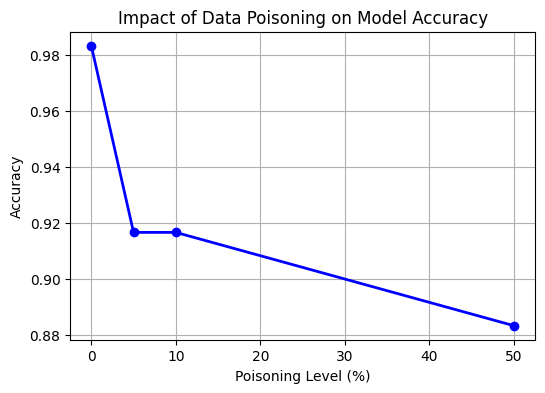

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

levels = [int(l * 100) for l, _ in results]
accuracies = [a for _, a in results]

plt.figure(figsize=(6, 4))
plt.plot(levels, accuracies, marker='o', linewidth=2, color='blue')
plt.title("Impact of Data Poisoning on Model Accuracy")
plt.xlabel("Poisoning Level (%)")
plt.ylabel("Accuracy")
plt.grid(True)

plt.savefig("poison_accuracy_plot.png", bbox_inches='tight')
mlflow.log_artifact("poison_accuracy_plot.png")

plt.show()


In [9]:
import os

# Directory containing your output files
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Move all generated artifacts to the output folder
for f in os.listdir():
    if f.startswith("report_") or f.endswith(".png") or f.endswith(".md"):
        os.replace(f, os.path.join(output_dir, f))

# Upload everything in outputs/ to your GCS bucket
BUCKET_URI = "gs://week8-assignment-mlops-steadfast-canto-473315-v8-unique"
!gsutil -m cp -r outputs/* {BUCKET_URI}/outputs/


Copying file://outputs/poison_accuracy_plot.png [Content-Type=image/png]...
Copying file://outputs/report_5.txt [Content-Type=text/plain]...                
Copying file://outputs/report_10.txt [Content-Type=text/plain]...
Copying file://outputs/report_0.txt [Content-Type=text/plain]...                
Copying file://outputs/report_50.txt [Content-Type=text/plain]...
/ [5/5 files][ 27.4 KiB/ 27.4 KiB] 100% Done                                    
Operation completed over 5 objects/27.4 KiB.                                     


## Validation Outcomes and Analysis — IRIS Data Poisoning

### Objective
To analyze how **data poisoning** (random Gaussian noise injection) at different levels (5%, 10%, 50%) affects model validation outcomes when trained on the **IRIS dataset**, and to log experiments using **MLflow**.

---

### ⚙️ Experiment Summary
We trained a **Decision Tree Classifier** on the IRIS dataset with various data poisoning levels applied only to the **training features**.  
Each run was tracked in MLflow, logging metrics, model parameters, accuracy scores, and classification reports.

| Poisoning Level | Model Accuracy | Observation |
|-----------------|----------------|--------------|
| **0%** | **0.983** | Baseline – clean data gives near-perfect accuracy. |
| **5%** | **0.917** | Slight drop — model still stable. |
| **10%** | **0.917** | Moderate poisoning slightly impacts performance. |
| **50%** | **0.883** | Heavy poisoning causes significant performance degradation. |

---

### Accuracy Trend
![Poisoning Accuracy Plot](poison_accuracy_plot.png)

**Interpretation:**  
The line plot shows a clear downward trend in model accuracy as the poisoning level increases.  
The clean (0%) model performs best, while the heavily poisoned (50%) model loses generalization capability due to distorted feature relationships.

---

###  Key Insights
- As **poisoning increases**, **model accuracy decreases** because feature relationships are corrupted.  
- Small noise (<10%) can be tolerated, but beyond that, the classifier begins to **misclassify more often**.  
- MLflow tracking provides transparent comparison across multiple experiment runs.  

---

##  How to Mitigate Data Poisoning Attacks

1. **Data Validation Pipelines**
   - Use anomaly detection, outlier filtering, and statistical sanity checks before training.
   - Validate dataset integrity through schema and range validation.

2. **Robust Model Training**
   - Use regularization or **noise-tolerant algorithms** (e.g., Random Forests, XGBoost).
   - Consider **robust loss functions** that reduce outlier sensitivity.

3. **Data Provenance and Versioning**
   - Track data lineage with tools like **DVC**, **MLflow**, or **Weights & Biases**.
   - Maintain checksums or dataset hashes to detect tampering.

4. **Access Control and Monitoring**
   - Limit write permissions to source datasets.
   - Enable logging of all data updates in the MLOps pipeline.

5. **Adversarial/Defensive Training**
   - Introduce small, controlled noise during training to **improve model resilience** against poisoning.

---

##  Data Quantity vs Data Quality

- When **data quality drops**, even **large datasets** fail to maintain accuracy.  
- Adding more **low-quality or poisoned data** only amplifies model confusion.  
- Therefore, **data quality assurance** is **more valuable** than simply increasing dataset size.  
- A smaller, cleaner dataset often outperforms a larger, noisy one.

---

###  Conclusion
This experiment demonstrates that:
- Even small-scale data poisoning (5–10%) affects validation outcomes.  
- Maintaining **data trust, provenance, and validation pipelines** is essential for ML reliability.  
- Integrating MLflow allows for **systematic tracking** and **impact visualization** of such data quality variations.
